# Big Data Analysis Project - Data Exploratory Analysis

### This is a course project for Concordia's Bigdata class (SOEN691 UU) by Dr. Tristan Glatard in Winter 2020.
*Team Members:*
- Le, Manh Quoc Dat (Student ID: 40153127)<br />
- Tran, Trong Tuan (Student ID: 40151694)<br />
- Phan, Vu Hong Hai (Student ID: 40154023)<br />
- Zhang, Yefei (Student ID: 40153319)<br />

Main project repository: https://github.com/HongHaiPV/concordia-bigdata-project <br />
Datasource: https://sites.google.com/eng.ucsd.edu/fitrec-project/home <br />
>Jianmo Ni, Larry Muhlstein, and Julian McAuley. 2019. Modeling Heart Rate and Activity Data for Personalized Fitness Recommendation. In Proceedings of the 2019 World Wide Web Conference (WWW’19), May 13–17, 2019, San
Francisco, CA, USA. ACM, New York, NY, USA, 11 pages. https://doi.org/10.1145/3308558.3313643
<br />

*The purpose of the following analysis is to have an insight of the data set and some initial visual inference, as well as looking for missing data & data imbalance.*

### Project Setup Environment
- Python version 3.5.6
- PySpark is the main framework to work with the big data set. For the detailed python enviroment and package setup, please follow the [guide from the lab](https://github.com/azazel7/BigData-Lab/blob/master/installation_guides/guide.md)
- Matplotlib for plotting.

### A. Initialize pyspark framework and load data into pyspark's dataframe
&ensp;&ensp;&ensp;&ensp;Import necessary modules/ libraries for use later and load the data set into spark dataframe:<br />
   *&ensp;&ensp;&ensp;&ensp;(Note: the raw data and metadata files are download from the source above, unzipped and put into `data` folder)*

In [1]:
import os
import sys
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit
from pyspark.sql.functions import desc
from pyspark.sql.functions import col
from pyspark.sql.functions import size
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.core.interactiveshell import InteractiveShell
import matplotlib
InteractiveShell.ast_node_interactivity = "all" # This helps auto print out the items without explixitly using 'print'

# Initialize a spark session.

conf = pyspark.SparkConf().setMaster("local[*]")\
        .set('spark.executor.heartbeatInterval', 10000)\
        .set('spark.network.timeout', 10000)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("BigData Project - Exploratory Analysis") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = './data/endomondoHR.json'
# Load the main data set into pyspark data frame 
df = spark.read.json(filename_data, mode="DROPMALFORMED")


### B. Let's have an overview of the raw data set
#### 1. Columns & types of the data set:
   *&ensp;&ensp;&ensp;&ensp;The data set has both **single value columns** (int, string) and column made of **arrays/list**.*

In [2]:
print("Schema of the data set:\n")
df.printSchema()

print("Details of column names and data types:")
DataFrame(df.dtypes, columns = ["Column Name", "Column Type"])


Schema of the data set:

root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)

Details of column names and data types:


,Column Name,Column Type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


#### 2. Data set description and display the first 5 rows:
*Based on the column type, data frame description and the first 5 rows, we know that **each data row** is a record of a **single workout** of a **single user**, with the associated workout type (`sport`) and orther data like `heart rates`, `locations` and record times (`timestamp`).*

In [3]:
print("Data frame describe (string and numeric columns only):")
df.describe().toPandas()

print("First 5 rows in the data set:")
df.limit(5).toPandas()


Data frame describe (string and numeric columns only):


,summary,gender,id,sport,url,userId
0,count,253020,253020,253020,253020,253020
1,mean,None,3.566244412926132E8,None,None,4619648.939783417
2,stddev,None,1.574845634895318E8,None,None,3932877.7296880507
3,min,female,99296,aerobics,https://www.endomondo.com/users/10014612/worko...,69
4,max,unknown,674008008,yoga,https://www.endomondo.com/users/9991401/workou...,15481421


First 5 rows in the data set:


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915
2,"[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....",male,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",389643739,"[60.17326201312244, 60.173205351457, 60.172969...","[24.64995657093823, 24.650197718292475, 24.651...","[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...",bike,"[1407858459, 1407858466, 1407858478, 140785849...",https://www.endomondo.com/users/10921915/worko...,10921915
3,"[28.6, 29.4, 29.4, 29.4, 28.0, 27.0, 25.2, 23....",male,"[99, 105, 113, 109, 112, 116, 116, 114, 114, 1...",386729739,"[60.173286236822605, 60.17323946580291, 60.173...","[24.649874344468117, 24.650242729112506, 24.65...","[7.4988, 15.4008, 17.8668, 21.5712, 24.1416, 3...",bike,"[1407432042, 1407432048, 1407432056, 140743206...",https://www.endomondo.com/users/10921915/worko...,10921915
4,"[32.0, 32.0, 32.0, 35.8, 36.2, 36.2, 36.2, 36....",male,"[110, 113, 114, 116, 123, 126, 129, 135, 137, ...",383186560,"[60.17329327762127, 60.17327332869172, 60.1732...","[24.64979832060635, 24.64992195367813, 24.6500...",None,bike (transport),"[1406909434, 1406909436, 1406909437, 140690943...",https://www.endomondo.com/users/10921915/worko...,10921915


#### 3. Samples of Some Queries to Get Familiar with the Data Set
*3.1. Show the `heart_rate` column, size of the `heart_rate` column, `timestamp` column, and size of the `timestamp` column in a specific workout ID:*

In [52]:
workout_id = 396826535

heart_rate_df = df \
    .select(
        df.id.alias("Activity ID"),
        df.sport.alias("Sport Type"),
        df.heart_rate.alias("Heart Rate"),
        size(df.heart_rate).alias("Size of Heart Rates"),
        df.timestamp.alias("Timestamp"),
        size(df.timestamp).alias("Size of Timestamps")
    ) \
    .filter(df.id == workout_id)

heart_rate_df.toPandas()


,Activity ID,Sport Type,Heart Rate,Size of Heart Rates,Timestamp,Size of Timestamps
0,396826535,bike,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",500,"[1408898746, 1408898754, 1408898765, 140889877...",500


*3.2. Find all the workout records that have missing data on `speed` column:<br/>
&ensp;&ensp;&ensp;&ensp;The original `speed` column is unreliable due to those missing data, so in the experiment we introduced two more derived columns: **derived distance** and **derived speed**.*

In [19]:
from pyspark.sql.functions import array_contains

missing_speed_df = df \
    .filter(array_contains(df.speed, 0))

missing_speed_df.toPandas()

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....",male,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",389643739,"[60.17326201312244, 60.173205351457, 60.172969...","[24.64995657093823, 24.650197718292475, 24.651...","[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...",bike,"[1407858459, 1407858466, 1407858478, 140785849...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[33.6, 32.4, 32.4, 32.0, 29.2, 27.8, 27.8, 27....",male,"[91, 100, 107, 105, 104, 108, 120, 114, 113, 1...",366977747,"[60.173228066414595, 60.173104433342814, 60.17...","[24.64970293454826, 24.65009386651218, 24.6508...","[3.96, 13.3524, 19.5012, 25.3764, 32.6124, 26....",bike,"[1404415397, 1404415406, 1404415421, 140441544...",https://www.endomondo.com/users/10921915/worko...,10921915
2,"[80.8, 81.4, 81.4, 81.4, 80.6, 79.4, 78.0, 76....",male,"[99, 104, 118, 121, 121, 123, 120, 120, 122, 1...",361714712,"[60.173290092498064, 60.17326452769339, 60.173...","[24.64966152794659, 24.64991264976561, 24.6507...","[5.4972, 13.878, 22.1076, 22.1724, 25.1316, 27...",bike,"[1403535990, 1403535995, 1403536004, 140353601...",https://www.endomondo.com/users/10921915/worko...,10921915
3,"[32.8, 31.2, 30.0, 30.2, 29.8, 26.6, 25.6, 25....",male,"[102, 110, 117, 117, 121, 119, 123, 126, 129, ...",361662390,"[60.17328456044197, 60.17325094901025, 60.1728...","[24.64972003363073, 24.650070061907172, 24.650...","[5.4288, 16.3044, 22.4496, 24.9048, 33.5304, 3...",bike,"[1403464723, 1403464728, 1403464742, 140346475...",https://www.endomondo.com/users/10921915/worko...,10921915
4,"[98.6, 98.6, 98.6, 98.6, 97.8, 97.8, 97.8, 97....",male,"[96, 96, 99, 100, 101, 103, 106, 108, 111, 113...",360780159,"[60.17329763621092, 60.17328799702227, 60.1732...","[24.65015740133822, 24.65020425617695, 24.6503...","[9.4536, 10.6596, 12.0456, 12.6, 12.9384, 14.0...",bike,"[1403377962, 1403377963, 1403377965, 140337796...",https://www.endomondo.com/users/10921915/worko...,10921915
5,"[34.6, 34.4, 34.4, 32.4, 31.0, 29.2, 28.6, 30....",male,"[92, 104, 112, 110, 106, 106, 111, 107, 114, 1...",359283997,"[60.17329721711576, 60.17324935644865, 60.1727...","[24.649710645899177, 24.650065284222364, 24.65...","[6.48, 15.5232, 15.6528, 19.8396, 31.3056, 26....",bike,"[1403115202, 1403115208, 1403115226, 140311523...",https://www.endomondo.com/users/10921915/worko...,10921915
6,"[0.0, 0.0, 0.0, 0.0, 0.0, -1.4, -2.2, -3.2, -4...",male,"[101, 107, 117, 123, 123, 125, 130, 128, 127, ...",351555391,"[60.17335094511509, 60.17328581772745, 60.1732...","[24.649986661970615, 24.650146253407, 24.65065...","[6.102, 15.8184, 19.2852, 23.9256, 22.4532, 26...",bike,"[1401902091, 1401902095, 1401902100, 140190210...",https://www.endomondo.com/users/10921915/worko...,10921915
7,"[24.0, 24.2, 24.2, 24.2, 24.2, 24.2, 24.2, 24....",male,"[101, 104, 107, 110, 111, 111, 110, 110, 110, ...",326542063,"[60.17325120046735, 60.1732259709388, 60.17319...","[24.64992782101035, 24.650206100195646, 24.650...","[13.0068, 14.5512, 15.4836, 16.7616, 17.0748, ...",bike (transport),"[1398015123, 1398015127, 1398015130, 139801513...",https://www.endomondo.com/users/10921915/worko...,10921915
8,"[79.4, 14.2, 13.6, 14.0, 15.2, 15.4, 15.4, 16....",male,"[84, 79, 91, 96, 100, 99, 100, 102, 111, 104, ...",57624067,"[43.837931184098125, 43.83784250356257, 43.837...","[10.520959245041013, 10.521079357713461, 10.52...","[0.0, 6.0929832, 14.1561165, 14.836357, 16.035...",bike,"[1337701595, 1337701636, 1337701656, 133770167...",https://www.endomondo.com/users/430859/workout...,430859
9,"[512.48, 510.999, 511.0, 512.0, 510.48, 510.0,...",female,"[84, 93, 92, 106, 115, 117, 123, 126, 126, 129...",369995230,"[47.654224, 47.654072, 47.654081, 47.654196, 4...","[12.161818, 12.161438, 12.161402, 12.161108, 1...","[8.327833, 5.440848, 10.36871, 8.755781, 10.67...",run,"[1404299560, 1404299582, 1404299583, 140429959...",https://www.endomondo.com/users/2793

*3.3. Show the workouts that have the minimum size of the `timestamp`:<br/>
&ensp;&ensp;&ensp;&ensp;Through this diagram we could **filter out** those values as they are not meaningful in **our training/test sets**, since they are just singular activities and we don't have to predict the future values.*

In [63]:
min_size_timestamp_df = df \
    .agg(functions.min(size(df.timestamp)).alias("size_timestamp"))

df_with_size_timestamp_column = df \
    .withColumn("size_timestamp", size(df.timestamp))

min_workout_df = df_with_size_timestamp_column \
    .join(min_size_timestamp_df, "size_timestamp")

min_workout_df.toPandas()


,size_timestamp,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,1,[19.8],male,[74],542503543,[55.71280843578279],[12.408222947269678],[0.0],run,[1434278094],https://www.endomondo.com/users/854368/workout...,854368
1,1,[20.4],male,[74],542503541,[55.71285093203187],[12.408183887600899],[0.0],bike,[1434278046],https://www.endomondo.com/users/854368/workout...,854368
2,1,[20.2],male,[74],542503540,[55.71286895312369],[12.40816150791943],[0.0],core stability training,[1434278044],https://www.endomondo.com/users/854368/workout...,854368
3,1,[5.8],male,[132],268334484,[52.0216417],[5.5667296],None,run,[1348247580],https://www.endomondo.com/users/13279851/worko...,13279851
4,1,[7.79],male,[71],45758167,[25.153726],[55.327018],None,bike,[1262648691],https://www.endomondo.com/users/22260/workouts...,22260
5,1,[6.0],male,[92],328684279,[52.4588292],[-0.2742704],None,run,[1398273126],https://www.endomondo.com/users/13693003/worko...,13693003
6,1,[70.2],male,[112],322777568,[51.85394190251827],[-0.11804703623056412],[15.9732],bike,[1396790117],https://www.endomondo.com/users/6539051/workou...,6539051
7,1,[226.2],male,[141],533209068,[40.86529936641455],[-75.62662468291819],[37.0152],bike,[1433100097],https://www.endomondo.com/users/7231044/workou...,7231044
8,1,[226.2],male,[142],533209067,[40.865277322009206],[-75.62676323577762],[35.3052],core stability training,[1433100096],https://www.endomondo.com/users/7231044/workou...,7231044
9,1,[1445.6],male,[82],482365010,[51.51241706684232],[-0.08988786488771439],[0.0],bike,[1425678010],https://www.endomondo.com/users/854633/workout...,854633


*3.4. Show the workouts the have the maximum `heart_rate` value:<br/>
&ensp;&ensp;&ensp;&ensp;I think we could **cross out** these values as well as they are abnormal and very rare people could get those `heart_rate` values.*

In [6]:
max_heart_rate_df = df \
    .agg(functions.max(df.heart_rate).alias("heart_rate")) \

new_df = df \
    .join(max_heart_rate_df, "heart_rate")

new_df.toPandas()


,heart_rate,altitude,gender,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[18514, 18397, 18321, 18245, 18170, 18095, 180...","[20.0, 18.0, 23.0, 27.0, 32.0, 35.0, 44.0, 40....",male,546620575,"[63.428644, 63.430593, 63.425403, 63.420105, 6...","[10.396154, 10.392685, 10.393611, 10.395587, 1...",None,bike,"[1434801922, 1434802038, 1434802114, 143480219...",https://www.endomondo.com/users/6793807/workou...,6793807


*3.5. Show the **workout type (`sport`)** that has many people joined:*

Top 10 sports that have most people playing:


,sport,count,percentage
0,run,865,29.0
1,bike,794,26.0
2,mountain bike,336,11.0
3,bike (transport),252,8.0
4,walk,209,7.0
5,core stability training,183,6.0
6,indoor cycling,180,6.0
7,hiking,92,3.0
8,cross-country skiing,70,2.0
9,fitness walking,48,2.0



Pie chart of the top 10 sports that have most people playing:


([<matplotlib.patches.Wedge at 0x7ff3a8aac898>,
 [Text(-0.9481859955696363, 0.7354884892407344, 'run'),
  Text(-0.5299291209321735, -0.9639373043865738, 'bike'),
  Text(0.6741976597375777, -0.8691705906232525, 'mountain bike'),
  Text(1.0461621265515308, -0.3399188211458422, 'bike (transport)'),
  Text(1.0864571964046237, 0.17207777422027873, 'walk'),
  Text(0.9287607944827384, 0.5894093540416481, 'core stability training'),
  Text(0.6465639004190118, 0.8899186045223206, 'indoor cycling'),
  Text(0.3726118617392651, 1.0349687920373247, 'hiking'),
  Text(0.20611960588532155, 1.0805159453102393, 'cross-country skiing'),
  Text(0.06906973696803673, 1.0978293908596026, 'fitness walking')],
 [Text(-0.5531084974156212, 0.4290349520570951, '29.0%'),
  Text(-0.2890522477811855, -0.5257839842108584, '26.0%'),
  Text(0.36774417803867876, -0.47409304943086494, '11.0%'),
  Text(0.5706338872099258, -0.18541026607955027, '8.0%'),
  Text(0.5926130162207037, 0.09386060412015203, '7.0%'),
  Text(0.5065

(-1.193752611195121,
 1.1072239933929329,
 -1.111903247074768,
 1.1647761338420373)

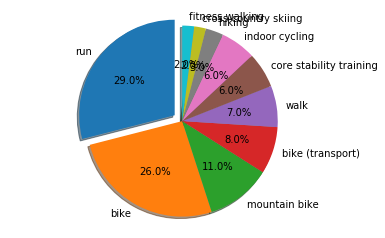

In [43]:
highest_sport_users_df = df \
    .select(
        df.sport,
        df.userId
    ) \
    .distinct() \
    .groupBy(df.sport) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(10) \
    .toPandas()

highest_sport_users_df["percentage"] = round((highest_sport_users_df["count"] / highest_sport_users_df["count"].sum()) * 100)

print("Top 10 sports that have most people playing:")
highest_sport_users_df

print("\nPie chart of the top 10 sports that have most people playing:")

labels = highest_sport_users_df["sport"]
sizes = highest_sport_users_df["percentage"]
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)

ax1 = plt.subplot()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()


*3.6. Find all people that participate in a specific `sport` and sorting by the **number of workouts** they did in **descending order**:*

,userId,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,date_time,count
0,8353647,"[214.2, 214.2, 214.2, 214.2, 214.2, 214.4, 214...",male,"[114, 114, 117, 121, 124, 129, 138, 142, 148, ...",386827622,"[28.6421619, 28.642154, 28.6421364, 28.6421204...","[77.1249684, 77.1249731, 77.1249963, 77.124977...",None,soccer,"[1407442866, 1407442867, 1407442875, 140744287...",https://www.endomondo.com/users/8353647/workou...,"[2014-08-07 16:21:06, 2014-08-07 16:21:07, 201...",34
1,8353647,"[205.6, 206.0, 206.4, 207.0, 207.6, 207.8, 208...",male,"[120, 115, 110, 109, 102, 109, 114, 107, 115, ...",392097656,"[28.642189, 28.6422249, 28.6422587, 28.6422669...","[77.1248063, 77.1247861, 77.1247931, 77.124731...",None,soccer,"[1408218610, 1408218614, 1408218619, 140821862...",https://www.endomondo.com/users/8353647/workou...,"[2014-08-16 15:50:10, 2014-08-16 15:50:14, 201...",34
2,8353647,"[214.2, 214.2, 214.2, 214.2, 214.2, 214.2, 214...",male,"[131, 132, 128, 124, 120, 116, 112, 108, 109, ...",392683430,"[28.6422177, 28.6422007, 28.6422143, 28.642202...","[77.1249471, 77.1249437, 77.1249242, 77.124925...",None,soccer,"[1408305245, 1408305249, 1408305256, 140830526...",https://www.endomondo.com/users/8353647/workou...,"[2014-08-17 15:54:05, 2014-08-17 15:54:09, 201...",34
3,8353647,"[229.0, 228.4, 227.2, 226.4, 225.8, 225.2, 223...",male,"[113, 109, 106, 107, 114, 119, 120, 123, 129, ...",393196660,"[28.6421105, 28.642135, 28.6421431, 28.6421167...","[77.1250262, 77.1250048, 77.1249524, 77.124949...",None,soccer,"[1408391209, 1408391213, 1408391220, 140839122...",https://www.endomondo.com/users/8353647/workou...,"[2014-08-18 15:46:49, 2014-08-18 15:46:53, 201...",34
4,8353647,"[222.8, 222.6, 222.6, 222.4, 222.0, 221.6, 221...",male,"[91, 100, 111, 121, 131, 135, 135, 136, 139, 1...",396676886,"[28.6415692, 28.6415275, 28.6415142, 28.641471...","[77.1259072, 77.125819, 77.1257065, 77.1255246...",None,soccer,"[1408909362, 1408909366, 1408909370, 140890937...",https://www.endomondo.com/users/8353647/workou...,"[2014-08-24 15:42:42, 2014-08-24 15:42:46, 201...",34
5,8353647,"[219.2, 219.6, 219.6, 220.0, 220.2, 220.4, 220...",male,"[146, 140, 135, 132, 129, 128, 129, 131, 130, ...",399484381,"[28.6421395, 28.6421718, 28.6421784, 28.642147...","[77.1250823, 77.1250718, 77.1250645, 77.125031...",None,soccer,"[1409343054, 1409343062, 1409343071, 140934308...",https://www.endomondo.com/users/8353647/workou...,"[2014-08-29 16:10:54, 2014-08-29 16:11:02, 201...",34
6,8353647,"[221.8, 221.8, 221.8, 221.8, 221.8, 221.6, 221...",male,"[152, 153, 154, 152, 151, 148, 147, 144, 141, ...",400538783,"[28.6421604, 28.6421665, 28.6421691, 28.642158...","[77.1249335, 77.1249406, 77.1249475, 77.124966...",None,soccer,"[1409515545, 1409515546, 1409515548, 140951555...",https://www.endomondo.com/users/8353647/workou...,"[2014-08-31 16:05:45, 2014-08-31 16:05:46, 201...",34
7,8353647,"[209.6, 209.6, 209.6, 209.6, 209.6, 209.6, 209...",male,"[166, 166, 164, 161, 157, 154, 150, 148, 145, ...",402785295,"[28.6418625, 28.6418551, 28.6418234, 28.641813...","[77.1251681, 77.1251547, 77.1251116, 77.125084...",None,soccer,"[1409776983, 1409776984, 1409776987, 140977698...",https://www.endomondo.com/users/8353647/workou...,"[2014-09-03 16:43:03, 2014-09-03 16:43:04, 201...",34
8,8353647,"[216.8, 216.8, 216.8, 216.6, 216.6, 216.4, 216...",male,"[105, 105, 106, 109, 112, 113, 111, 107, 102, ...",402785282,"[28.6421887, 28.6421882, 28.6421849, 28.642238...","[77.1249879, 77.124986, 77.124983, 77.1249365,...",None,soccer,"[1409860907, 1409860908, 1409860911, 140986091...",https://www.endomondo.com/users/8353647/workou...,"[2014-09-04 16:01:47, 2014-09-04 16:01:48, 201...",34
9,8353647,"[227.2, 226.8, 226.4, 226.0, 225.8, 225.4, 225...",male,"[123, 126, 129, 130, 132, 138, 138, 136, 132, ...",403897452,"[28.642988, 28.6429741, 28.6429289, 28.6428463...","[77.1252531, 77.1251241, 77.1250568, 77.125045...",None,soccer,"[1410033033, 1410033037, 1410033042, 


Graph for the above data:


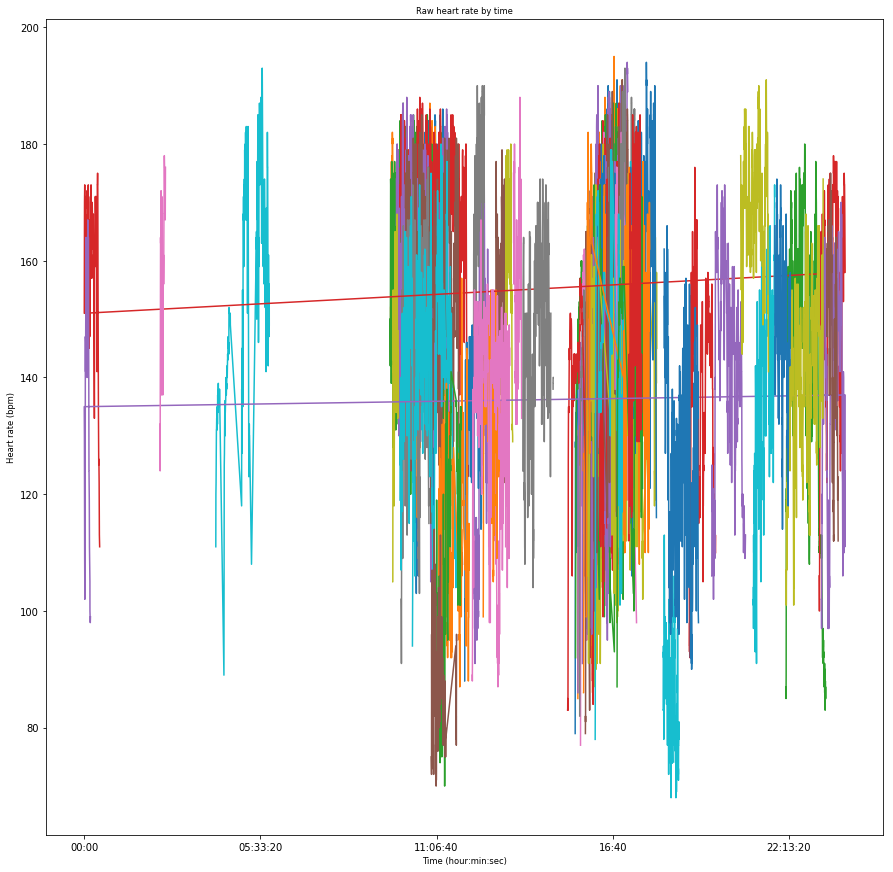

In [19]:
from datetime import datetime
from pyspark.sql.types import *
from pyspark.sql.functions import udf

sport = "soccer"

def convert_to_datetime(timestamps):
    return [datetime.fromtimestamp(int(ts)) for ts in timestamps]

# Register the support function 'to_time' as a user defined function into pyspark framework
udf_convert_to_datetime = udf(convert_to_datetime, ArrayType(elementType=TimestampType()))

new_df = df \
    .withColumn("date_time", udf_convert_to_datetime('timestamp'))

people_sport_df = new_df \
    .filter(new_df.sport == sport) \
    .groupBy(new_df.userId) \
    .count() \
    .orderBy("count", ascending = False)

detailed_info_df = new_df \
    .join(people_sport_df, "userId") \
    .filter(new_df.sport == sport) \
    .orderBy(["count", "timestamp"], ascending = [0, 1])

detailed_info_df.toPandas()

print("\nGraph for the above data:")

fig, axs = plt.subplots(1, figsize=(15, 15))
a = fig.subplots_adjust(hspace = 0.5)

for idx, data_row in detailed_info_df.toPandas().iterrows():
    label = "user: " + str(data_row['userId'])
    data_row['date_time'] = [date_time.time() for date_time in data_row['date_time']]
    a = axs.plot(data_row["date_time"], data_row["heart_rate"], label=label)

a = axs.set_title("Raw heart rate by time",fontsize = "small")
a = axs.set_ylabel("Heart rate (bpm)", fontsize = "small")
a = axs.set_xlabel("Time (hour:min:sec)", fontsize = "small")


*3.7 Find the person who has the **longest workout time**:<br/>
&ensp;&ensp;&ensp;&ensp;It could be possible to filter out this row as it would be an outlier in our training set.*

In [29]:
def get_duration(datetime_list):
    return (max(datetime_list) - min(datetime_list)).seconds / 60

# Register the support function 'get_duration' as a user defined function into pyspark framework
udf_get_duration = udf(get_duration, FloatType())

duration_df = new_df.withColumn("duration", udf_get_duration("date_time"))

max_workout_duration_df = duration_df \
    .agg(functions.max(duration_df.duration).alias("duration"))

result_df = max_workout_duration_df \
    .join(duration_df, "duration") \
    .select(
        duration_df.userId,
        duration_df.heart_rate,
        duration_df.sport,
        duration_df.timestamp,
        max_workout_duration_df.duration)

result_df.toPandas()


,userId,heart_rate,sport,timestamp,duration
0,2894897,"[86, 91, 90, 79, 80, 95, 93, 101, 100, 94, 100...",run,"[1440820805, 1440820944, 1440821088, 144082127...",1439.966675


*3.8. Find people who participated in **more than 1 `sport`**:*

In [36]:
min_number_of_sports = 1

sport_df = df \
    .select(df.userId, df.sport) \
    .distinct() \
    .groupBy(df.userId) \
    .count()    

sport_df \
    .filter(sport_df["count"] > min_number_of_sports) \
    .orderBy("count", ascending = False) \
    .toPandas()

,userId,count
0,8281868,16
1,5727574,13
2,2894897,13
3,8276277,12
4,331586,12
5,212295,11
6,150436,11
7,2159610,11
8,3417701,11
9,5072565,11


*3.9. Find users that have **at least 10 workout records** per **`sport`**:<br/>
&ensp;&ensp;&ensp;&ensp;According to [the main paper](http://cseweb.ucsd.edu/~jmcauley/pdfs/www19.pdf), we are interested in users with at least 10 workout records for future personalization strategies works.*

In [24]:
qualified_df = df \
    .select(df.sport, df.userId) \
    .groupBy(df.sport, df.userId) \
    .count()

print("Total workout records per user per sport with minimum workout recorded is 10:")
qualified_df \
    .filter(qualified_df["count"] >= 10) \
    .orderBy("count", ascending = False) \
    .toPandas()

print("Total workout records of all users:")
qualified_df.agg(functions.sum(qualified_df["count"])).toPandas()


Total workout records per user per sport with minimum workout recorded is 10:


,sport,userId,count
0,bike,3714939,2783
1,run,1063624,1874
2,run,1520156,1755
3,bike,10821441,1666
4,run,2915343,1516
5,bike,65547,1221
6,bike (transport),2734298,1218
7,run,983950,1062
8,bike,9051351,1057
9,bike,804068,1033


Total workout records of all users:


,sum(count)
0,253020
